## PDE 1 - 2D


#### Problem Setup

$\phi u + u_{x} + u_{y,y} = f(x,y)$

For the generation of our initial data samples we use:

$\phi = 2$ <br>
$u: \mathbb{R}^2 \rightarrow \mathbb{R}, \; u(x,y) = x^2 + y$ <br>
$f: \mathbb{R}^2 \rightarrow \mathbb{R}, \;f(x,y) = 2(x^2 + x + y)$ <br>
$X_i := (x_i, y_i) \in [0,1] \times [0,1] \in \mathbb{R}^2$ for $i \in \{1, \dotsc, n\}$ 

and our known function values will be $\{u(x_i,y_i), f(x_i,y_i)\}_{i \in \{1, \dotsc, n\}}$.

We assume that $u$ can be represented as a Gaussian process with SE kernel.

$u \sim \mathcal{GP}(0, k_{uu}(X_i, X_j; \theta))$, where $\theta = \{\sigma, l_x, l_y\}$.

Set the linear operator to:

$\mathcal{L}_X^{\phi} := \phi + \partial_x + \partial_{y,y}$

so that

$\mathcal{L}_X^{\phi} u = f$

Problem at hand: Estimate $\phi$ (we expect $\phi = 2$).


#### Step 1: Simulate data

In [1]:
import time
import numpy as np
import sympy as sp
from scipy.linalg import solve_triangular
import scipy.optimize as opt

In [2]:
# Global variables: x, y, n, y_u, y_f, s

*Parameters, that can be modified:*

In [26]:
# Number of data samples:
n = 5

# Noise of our data:
s = 1e-7

In [4]:
def simulate_data():
    x = np.random.rand(n)
    y = np.random.rand(n)
    y_u = np.multiply(x,x) + y
    y_f = 2*(np.multiply(x,x) + x + y)
    return (x,y,y_u,y_f)
(x,y,y_u,y_f) = simulate_data()

#### Step 2: Evaluate kernels

$k_{uu}(X_i, X_j; \theta) = \sigma exp(-\frac{1}{2l_x}(x_i-x_j)^2 - \frac{1}{2l_y}(y_i-y_j)^2)$

In [5]:
x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi = sp.symbols('x_i x_j y_i y_j sigma l_x l_y phi')
kuu_sym = sigma*sp.exp(-1/(2*l_x)*((x_i - x_j)**2) - 1/(2*l_y)*((y_i - y_j)**2))
kuu_fn = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y), kuu_sym, "numpy")
def kuu(x, y, sigma, l_x, l_y):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kuu_fn(x[i], x[j], y[i], y[j], sigma, l_x, l_y)
    return k

$k_{ff}(X_i,X_j;\theta,\phi) \\
= \mathcal{L}_{X_i}^{\phi} \mathcal{L}_{X_j}^{\phi} k_{uu}(X_i, X_j; \theta) \\
= \phi^2k_{uu} + \phi \frac{\partial}{\partial x_i}k_{uu} + \phi \frac{\partial^2}{\partial y_i^2}k_{uu} + \phi \frac{\partial}{\partial x_j}k_{uu} + \frac{\partial^2}{\partial x_i, x_j}k_{uu} + \frac{\partial^3}{\partial y_i^2 \partial x_j}k_{uu} + \phi \frac{\partial^2}{\partial y_j^2}k_{uu} + \frac{\partial^3}{\partial x_i \partial y_j^2}k_{uu} + \frac{\partial^4}{\partial y_i^2 \partial y_j^2}k_{uu}$

In [6]:
kff_sym = phi**2*kuu_sym \
        + phi*sp.diff(kuu_sym, x_i) \
        + phi*sp.diff(kuu_sym, y_i, y_i) \
        + phi*sp.diff(kuu_sym, x_j) \
        + sp.diff(kuu_sym, x_i, x_j) \
        + sp.diff(kuu_sym, y_i, y_i, x_j) \
        + phi*sp.diff(kuu_sym, y_j, y_j) \
        + sp.diff(kuu_sym, x_i, y_j, y_j) \
        + sp.diff(kuu_sym, y_i, y_i, y_j, y_j)
kff_fn = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kff_sym, "numpy")
def kff(x, y, sigma, l_x, l_y, phi):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kff_fn(x[i], x[j], y[i], y[j], sigma, l_x, l_y, phi)
    return k

$k_{fu}(X_i,X_j;\theta,\phi) \\
= \mathcal{L}_{X_i}^{\phi} k_{uu}(X_i, X_j; \theta) \\
= \phi k_{uu} + \frac{\partial}{\partial x_i}k_{uu} + \frac{\partial^2}{\partial y_i^2}k_{uu}$

In [7]:
kfu_sym = phi*kuu_sym \
        + sp.diff(kuu_sym, x_i) \
        + sp.diff(kuu_sym, y_i, y_i)
kfu_fn = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kfu_sym, "numpy")
def kfu(x, y, sigma, l_x, l_y, phi):
    k = np.zeros((x.size, x.size))
    for i in range(x.size):
        for j in range(x.size):
            k[i,j] = kfu_fn(x[i], x[j], y[i], y[j], sigma, l_x, l_y, phi)
    return k

In [8]:
def kuf(x, y, sigma, l_x, l_y, phi):
    return kfu(x, y, sigma, l_x, l_y, phi).T

#### Step 3: Computing the negative log-likelihood (with block matrix inversion, Cholesky decomposition, potentially SVD)

We use the block-inversion technique: Let
$ K = \begin{pmatrix} K_{uu} & K_{uf} \\ K_{fu} & K_{ff} \end{pmatrix} = \begin{pmatrix} A & B \\ B^T & C \end{pmatrix}$. 

Then $det(K) = det(A) det(C-B^T A^{-1} B)$.

$K^{-1} = \begin{pmatrix} A^{-1} + A^{-1} B(C-B^T A^{-1} B)^{-1}B^T A^{-1} & -A^{-1}B(C-B^T A^{-1} B)^{-1} \\
            -(C - B^T A^{-1}B)^{-1}B^T A^{-1} & (C-B^T A^{-1} B)^{-1} \end{pmatrix}$
            
So it suffices to invert $A$ and $C-B^T A^{-1} B$.

A theorem about Schur-complements ensures that $K$ positive-definite implies the positive-definiteness of $K/A = C-B^T A^{-1} B$ as well, so Cholesky should work as well.

In [9]:
def nlml(params):
    
    sigma_exp = np.exp(params[0])
    l_x_exp = np.exp(params[1])
    l_y_exp = np.exp(params[2])
    # phi = params[3]
    
    A = kuu(x, y, sigma_exp, l_x_exp, l_y_exp) + s*np.eye(n)
    B = kfu(x, y, sigma_exp, l_x_exp, l_y_exp, params[3]).T
    C = kff(x, y, sigma_exp, l_x_exp, l_y_exp, params[3]) + s*np.eye(n)
    
    # Inversion of A
    A_inv = np.zeros((n, n))
    
    try:
        L = np.linalg.cholesky(A)
        L_inv = solve_triangular(L, np.identity(n), lower=True) # Slight performance boost over np.linalg.inv
        A_inv = L_inv.T @ L_inv
        logdet_A = 2*np.log(np.abs(np.diag(L))).sum()
    except np.linalg.LinAlgError:
        # Inverse of K via SVD
        u, s_mat, vt = np.linalg.svd(A)
        A_inv = vt.T @ np.linalg.inv(np.diag(s_mat)) @ u.T
        logdet_A = np.log(s_mat).sum()
        
    # Inversion of $C-B^T A^{-1} B$
    KA_inv = np.zeros((n, n))
    KA = C - B.T @ A_inv @ B
    
    try:
        L = np.linalg.cholesky(KA)
        L_inv = solve_triangular(L, np.identity(n), lower=True) # Slight performance boost over np.linalg.inv
        KA_inv = L_inv.T @ L_inv
        logdet_KA = 2*np.log(np.abs(np.diag(L))).sum()
    except np.linalg.LinAlgError:
        # Inverse of K via SVD
        u, s_mat, vt = np.linalg.svd(KA)
        KA_inv = vt.T @ np.linalg.inv(np.diag(s_mat)) @ u.T
        logdet_KA = np.log(s_mat).sum()
        
    # Piecing it together
    T = A_inv @ B @ KA_inv
    yKy = y_u @ (A_inv + T @ B.T @ A_inv) @ y_u - 2*y_u @ T @ y_f + y_f @ KA_inv @ y_f
    
    return (yKy + logdet_A + logdet_KA)

#### Step 4: Optimize hyperparameters

**1. Nelder-Mead**

In [10]:
Nfeval = 1
def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], Xi[3]))
    Nfeval += 1

In [11]:
t0 = time.time()
m_n = opt.minimize(nlml, np.random.rand(4), method="Nelder-Mead", callback = callbackF,
                                        options={'maxfev':5000, 'fatol':0.001, 'xatol':0.001})
t_Nelder = time.time() - t0

   1    0.586232    0.047820    0.386668    1.024025
   2    0.586232    0.047820    0.386668    1.024025
   3    0.635695    0.047372    0.364918    1.057549
   4    0.592186    0.047036    0.348605    1.119265
   5    0.592186    0.047036    0.348605    1.119265
   6    0.601861    0.048451    0.349587    1.206981
   7    0.657550    0.045337    0.302443    1.319818
   8    0.657550    0.045337    0.302443    1.319818
   9    0.614576    0.049591    0.248726    1.510283
  10    0.667550    0.047659    0.219130    1.778404
  11    0.667550    0.047659    0.219130    1.778404
  12    0.763472    0.049979    0.082721    2.136234
  13    0.763472    0.049979    0.082721    2.136234
  14    0.763472    0.049979    0.082721    2.136234
  15    0.703690    0.049471    0.108801    2.122311
  16    0.692227    0.047221    0.160488    1.910864
  17    0.692227    0.047221    0.160488    1.910864
  18    0.694164    0.048206    0.168049    1.923514
  19    0.694164    0.048206    0.168049    1.

 157    0.707749    0.048390    0.137849    1.999783
 158    0.707749    0.048390    0.137849    1.999783
 159    0.707749    0.048390    0.137849    1.999783
 160    0.707749    0.048390    0.137849    1.999783
 161    0.707749    0.048390    0.137849    1.999783
 162    0.707749    0.048390    0.137849    1.999783
 163    0.707749    0.048390    0.137849    1.999783
 164    0.707749    0.048390    0.137849    1.999783
 165    0.707749    0.048390    0.137849    1.999783
 166    0.707749    0.048390    0.137849    1.999783
 167    0.707749    0.048390    0.137849    1.999783
 168    0.707749    0.048390    0.137849    1.999783
 169    0.707749    0.048390    0.137849    1.999783
 170    0.707749    0.048390    0.137849    1.999783
 171    0.707749    0.048390    0.137849    1.999783
 172    0.707749    0.048390    0.137849    1.999783
 173    0.707749    0.048390    0.137849    1.999783
 174    0.707749    0.048390    0.137849    1.999783
 175    0.707749    0.048390    0.137849    1.

 312    0.707749    0.048390    0.137849    1.999783
 313    0.707749    0.048390    0.137849    1.999783
 314    0.707749    0.048390    0.137849    1.999783
 315    0.707749    0.048390    0.137849    1.999783
 316    0.707749    0.048390    0.137849    1.999783
 317    0.707749    0.048390    0.137849    1.999783
 318    0.707749    0.048390    0.137849    1.999783
 319    0.707749    0.048390    0.137849    1.999783
 320    0.707749    0.048390    0.137849    1.999783
 321    0.707749    0.048390    0.137849    1.999783
 322    0.707749    0.048390    0.137849    1.999783
 323    0.707749    0.048390    0.137849    1.999783
 324    0.707749    0.048390    0.137849    1.999783
 325    0.707749    0.048390    0.137849    1.999783
 326    0.707749    0.048390    0.137849    1.999783
 327    0.707749    0.048390    0.137849    1.999783
 328    0.707749    0.048390    0.137849    1.999783
 329    0.707749    0.048390    0.137849    1.999783
 330    0.707749    0.048390    0.137849    1.

 468    0.707749    0.048390    0.137849    1.999783
 469    0.707749    0.048390    0.137849    1.999783
 470    0.707749    0.048390    0.137849    1.999783
 471    0.707749    0.048390    0.137849    1.999783
 472    0.707749    0.048390    0.137849    1.999783
 473    0.707749    0.048390    0.137849    1.999783
 474    0.707749    0.048390    0.137849    1.999783
 475    0.707749    0.048390    0.137849    1.999783
 476    0.707749    0.048390    0.137849    1.999783
 477    0.707749    0.048390    0.137849    1.999783
 478    0.707749    0.048390    0.137849    1.999783
 479    0.707749    0.048390    0.137849    1.999783
 480    0.707749    0.048390    0.137849    1.999783
 481    0.707749    0.048390    0.137849    1.999783
 482    0.707749    0.048390    0.137849    1.999783
 483    0.707749    0.048390    0.137849    1.999783
 484    0.707749    0.048390    0.137849    1.999783
 485    0.707749    0.048390    0.137849    1.999783
 486    0.707749    0.048390    0.137849    1.

 623    0.707749    0.048390    0.137849    1.999783
 624    0.707749    0.048390    0.137849    1.999783
 625    0.707749    0.048390    0.137849    1.999783
 626    0.707749    0.048390    0.137849    1.999783
 627    0.707749    0.048390    0.137849    1.999783
 628    0.707749    0.048390    0.137849    1.999783
 629    0.707749    0.048390    0.137849    1.999783
 630    0.707749    0.048390    0.137849    1.999783
 631    0.707749    0.048390    0.137849    1.999783
 632    0.707749    0.048390    0.137849    1.999783
 633    0.707749    0.048390    0.137849    1.999783
 634    0.707749    0.048390    0.137849    1.999783
 635    0.707749    0.048390    0.137849    1.999783
 636    0.707749    0.048390    0.137849    1.999783
 637    0.707749    0.048390    0.137849    1.999783
 638    0.707749    0.048390    0.137849    1.999783
 639    0.707749    0.048390    0.137849    1.999783
 640    0.707749    0.048390    0.137849    1.999783
 641    0.707749    0.048390    0.137849    1.

 778    0.707749    0.048390    0.137849    1.999783
 779    0.707749    0.048390    0.137849    1.999783
 780    0.707749    0.048390    0.137849    1.999783
 781    0.707749    0.048390    0.137849    1.999783
 782    0.707749    0.048390    0.137849    1.999783
 783    0.707749    0.048390    0.137849    1.999783
 784    0.707749    0.048390    0.137849    1.999783
 785    0.707749    0.048390    0.137849    1.999783
 786    0.707749    0.048390    0.137849    1.999783
 787    0.707749    0.048390    0.137849    1.999783
 788    0.707749    0.048390    0.137849    1.999783
 789    0.707749    0.048390    0.137849    1.999783
 790    0.707749    0.048390    0.137849    1.999783
 791    0.707749    0.048390    0.137849    1.999783
 792    0.707749    0.048390    0.137849    1.999783
 793    0.707749    0.048390    0.137849    1.999783
 794    0.707749    0.048390    0.137849    1.999783
 795    0.707749    0.048390    0.137849    1.999783
 796    0.707749    0.048390    0.137849    1.

**2. Nonlinear Conjugate Gradient**

The partial derivatives for $L(\theta, \phi) := \log(\lvert K(\theta, \phi) \rvert) + y^T [K(\theta, \phi)]^{-1} y$ are given by: <br>
\begin{equation}
\frac{\partial L}{\partial \theta_i}(\theta, \phi) = tr(K^{-1}\frac{\partial K}{\partial \theta_i}) - y^T K^{-1}\frac{\partial K}{\partial \theta_i} K^{-1}y
\end{equation}

\begin{equation}
\frac{\partial L}{\partial \phi}(\theta, \phi) = tr(K^{-1}\frac{\partial K}{\partial \phi}) - y^T K^{-1}\frac{\partial K}{\partial \phi} K^{-1}y
\end{equation}

Since $nlml(\sigma, l_x, l_y, \phi) = L(e^{\sigma}, e^{l_x}, e^{l_y}, \phi)$,  it follows:

\begin{equation}
\nabla nlml(\sigma, l_x, l_y, \phi) = (\nabla_{(e^{\sigma}, e^{l_x}, e^{l_y}, \phi)}L)^T
\begin{pmatrix}
e^{\sigma} &0&0&0\\
0&e^{l_x}&0&0 \\
0&0&e^{l_y}&0 \\
0&0&0&1
\end{pmatrix}
\end{equation}

Building the gradient:

In [12]:
kuu_sym_sigma, kuu_sym_l_x, kuu_sym_l_y, kuu_sym_phi = [sp.diff(kuu_sym, l) for l in [sigma, l_x, l_y, phi]]
kfu_sym_sigma, kfu_sym_l_x, kfu_sym_l_y, kfu_sym_phi = [sp.diff(kfu_sym, l) for l in [sigma, l_x, l_y, phi]]
kff_sym_sigma, kff_sym_l_x, kff_sym_l_y, kff_sym_phi = [sp.diff(kff_sym, l) for l in [sigma, l_x, l_y, phi]]

In [13]:
kuu_sigma = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y), kuu_sym_sigma, "numpy")
kff_sigma = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kff_sym_sigma, "numpy")
kfu_sigma = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kfu_sym_sigma, "numpy")

kuu_l_x = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y), kuu_sym_l_x, "numpy")
kff_l_x = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kff_sym_l_x, "numpy")
kfu_l_x = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kfu_sym_l_x, "numpy")

kuu_l_y = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y), kuu_sym_l_y, "numpy")
kff_l_y = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kff_sym_l_y, "numpy")
kfu_l_y = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kfu_sym_l_y, "numpy")

kuu_phi = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y), kuu_sym_phi, "numpy")
kff_phi = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kff_sym_phi, "numpy")
kfu_phi = sp.lambdify((x_i, x_j, y_i, y_j, sigma, l_x, l_y, phi), kfu_sym_phi, "numpy")

# Derivative of K w.r.t. sigma:
def K_sigma(x, y, sigma, l_x, l_y, phi):
    k = np.zeros([2*n, 2*n])
    for i in range(2*n):
        for j in range(2*n):
            if i<n and j<n:
                k[i,j] = kuu_sigma(x[i], x[j], y[i], y[j], sigma, l_x, l_y)
            if i<n and j>=n:
                k[i,j] = kfu_sigma(x[j-n], x[i], y[j-n], y[i], sigma, l_x, l_y, phi) # Transpose of kfu
            if i>=n and j<n:
                k[i,j] = kfu_sigma(x[i-n], x[j], y[i-n], y[j], sigma, l_x, l_y, phi)
            if i>=n and j>=n:
                k[i,j] = kff_sigma(x[i-n], x[j-n], y[i-n], y[j-n], sigma, l_x, l_y, phi)
    return k

# Derivative of K w.r.t. l_x:
def K_l_x(x, y, sigma, l_x, l_y, phi):
    k = np.zeros([2*n, 2*n])
    for i in range(2*n):
        for j in range(2*n):
            if i<n and j<n:
                k[i,j] = kuu_l_x(x[i], x[j], y[i], y[j], sigma, l_x, l_y)
            if i<n and j>=n:
                k[i,j] = kfu_l_x(x[j-n], x[i], y[j-n], y[i], sigma, l_x, l_y, phi) # Transpose of kfu
            if i>=n and j<n:
                k[i,j] = kfu_l_x(x[i-n], x[j], y[i-n], y[j], sigma, l_x, l_y, phi)
            if i>=n and j>=n:
                k[i,j] = kff_l_x(x[i-n], x[j-n], y[i-n], y[j-n], sigma, l_x, l_y, phi)
    return k

# Derivative of K w.r.t. l_y:
def K_l_y(x, y, sigma, l_x, l_y, phi):
    k = np.zeros([2*n, 2*n])
    for i in range(2*n):
        for j in range(2*n):
            if i<n and j<n:
                k[i,j] = kuu_l_y(x[i], x[j], y[i], y[j], sigma, l_x, l_y)
            if i<n and j>=n:
                k[i,j] = kfu_l_y(x[j-n], x[i], y[j-n], y[i], sigma, l_x, l_y, phi) # Transpose of kfu
            if i>=n and j<n:
                k[i,j] = kfu_l_y(x[i-n], x[j], y[i-n], y[j], sigma, l_x, l_y, phi)
            if i>=n and j>=n:
                k[i,j] = kff_l_y(x[i-n], x[j-n], y[i-n], y[j-n], sigma, l_x, l_y, phi)
    return k

# Derivative of K w.r.t. phi:
def K_phi(x, y, sigma, l_x, l_y, phi):
    k = np.zeros([2*n, 2*n])
    for i in range(2*n):
        for j in range(2*n):
            if i<n and j<n:
                k[i,j] = kuu_phi(x[i], x[j], y[i], y[j], sigma, l_x, l_y)
            if i<n and j>=n:
                k[i,j] = kfu_phi(x[j-n], x[i], y[j-n], y[i], sigma, l_x, l_y, phi) # Transpose of kfu
            if i>=n and j<n:
                k[i,j] = kfu_phi(x[i-n], x[j], y[i-n], y[j], sigma, l_x, l_y, phi)
            if i>=n and j>=n:
                k[i,j] = kff_phi(x[i-n], x[j-n], y[i-n], y[j-n], sigma, l_x, l_y, phi)
    return k

In [14]:
def K_inverse(sigma, l_x, l_y, phi):
    
    A = kuu(x, y, sigma, l_x, l_y) + s*np.eye(n)
    B = kfu(x, y, sigma, l_x, l_y, phi).T
    C = kff(x, y, sigma, l_x, l_y, phi) + s*np.eye(n)
    
    # Inversion of A
    A_inv = np.zeros((n, n))
    
    try:
        L = np.linalg.cholesky(A)
        L_inv = solve_triangular(L, np.identity(n), lower=True) # Slight performance boost over np.linalg.inv
        A_inv = L_inv.T @ L_inv
    except np.linalg.LinAlgError:
        # Inverse of K via SVD
        u, s_mat, vt = np.linalg.svd(A)
        A_inv = vt.T @ np.linalg.inv(np.diag(s_mat)) @ u.T
        
    # Inversion of $C-B^T A^{-1} B$
    KA_inv = np.zeros((n, n))
    KA = C - B.T @ A_inv @ B
    
    try:
        L = np.linalg.cholesky(KA)
        L_inv = solve_triangular(L, np.identity(n), lower=True) # Slight performance boost over np.linalg.inv
        KA_inv = L_inv.T @ L_inv
    except np.linalg.LinAlgError:
        # Inverse of K via SVD
        u, s_mat, vt = np.linalg.svd(KA)
        KA_inv = vt.T @ np.linalg.inv(np.diag(s_mat)) @ u.T
        
    # Piecing it together
    T = A_inv @ B @ KA_inv
        
    K_inv = np.block([
        [A_inv + T @ B.T @ A_inv, -T],
        [-T.T, KA_inv]
    ])
    
    return K_inv

In [15]:
# Setting the gradient:
def grad_L(sigma, l_x, l_y, phi, s):
    K_inv = K_inverse(sigma, l_x, l_y, phi)
#     print(K_inverse(sigma, l_x, l_y, phi))
    
    y_con = np.concatenate((y_u, y_f))
    comp_1 = np.trace(K_inv.dot(K_sigma(x, y, sigma, l_x, l_y, phi))) - \
             (y_con.T).dot(K_inv).dot(K_sigma(x, y, sigma, l_x, l_y, phi)).dot(K_inv).dot(y_con)
    comp_2 = np.trace(K_inv.dot(K_l_x(x, y, sigma, l_x, l_y, phi))) - \
             (y_con.T).dot(K_inv).dot(K_l_x(x, y, sigma, l_x, l_y, phi)).dot(K_inv).dot(y_con)
    comp_3 = np.trace(K_inv.dot(K_l_y(x, y, sigma, l_x, l_y, phi))) - \
             (y_con.T).dot(K_inv).dot(K_l_y(x, y, sigma, l_x, l_y, phi)).dot(K_inv).dot(y_con)
    comp_4 = np.trace(K_inv.dot(K_phi(x, y, sigma, l_x, l_y, phi))) - \
             (y_con.T).dot(K_inv).dot(K_phi(x, y, sigma, l_x, l_y, phi)).dot(K_inv).dot(y_con)
    return [comp_1, comp_2, comp_3, comp_4]

def grad_nlml(par):
    # sigma = par[0]
    # l_x = par[1]
    # l_y = par[2]
    # phi = par[3]
    M = np.diag([np.exp(par[0]), np.exp(par[1]), np.exp(par[2]), 1])
    grad = np.array([grad_L(np.exp(par[0]), np.exp(par[1]), np.exp(par[2]), par[3], s)]).dot(M)
    
    # Scipy.minimize wants an array as the gradient, not a matrix. 
    # We therefore remove any one-dimensional entries of the grad by squeezing.
    return np.squeeze(np.asarray(grad))

Run the conjugate gradient method:

In [16]:
Nfeval = 1

In [17]:
import conjugate_gradient._minimize as mi

In [18]:
t1 = time.time()
m = mi.minimize(nlml, np.random.rand(4), jac=grad_nlml, method='CG', callback = callbackF)
t_CG = time.time() - t1

   1    0.132043    0.332153    0.154280    1.628256
   2    0.133594    0.329288    0.147850    1.933769
   3    0.133708    0.329171    0.147714    1.995426
   4    0.133759    0.329136    0.147876    2.000100
   5    0.133853    0.329068    0.148194    2.000475
   6    0.295579    0.210490    0.698028    1.991637
   7    0.620095   -0.027310    1.801335    1.997384
   8    0.620123   -0.027223    1.801400    1.999851
   9    0.852281    0.686640    2.325283    1.999854
  10    0.852281    0.686640    2.325283    1.999854


------------------------------------------

**Plotting nlml close to the optimum in direction of the gradient**

*Gradient-based optimization is difficult as we're dealing with numerical instabilities:*

In [19]:
import matplotlib.pyplot as plt

Text(0,0.5,'$\\mathcal{NLL}(x_{opt} + \\alpha \\cdot \\nabla \\mathcal{NLL}(x_{opt}))$')

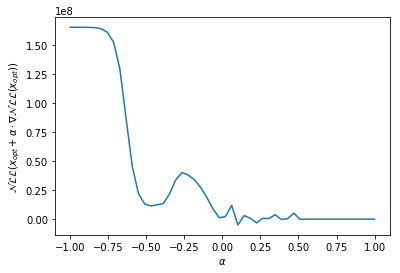

In [20]:
lin = np.linspace(-1, 1)

def plotting(alpha):
    return nlml(np.array(m.x) - alpha*np.array(m.jac))

out = [plotting(l) for l in lin]

plt.plot(lin, out)
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\mathcal{NLL}(x_{opt} + \alpha \cdot \nabla \mathcal{NLL}(x_{opt}))$')
#plt.savefig('Long_range.pdf')

Text(0.5,0,'$\\alpha$')

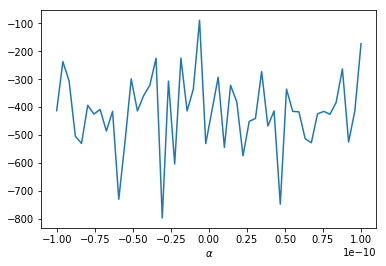

In [21]:
lin = np.linspace(-1e-10, 1e-10)

def plotting(alpha):
    return nlml(np.array(m.x) - alpha*np.array(m.jac))

out = [plotting(l) for l in lin]

plt.plot(lin, out)
plt.xlabel(r'$\alpha$')
#plt.savefig('Short_range.pdf')

------------------------------------------------

**3. ADAM**

In [22]:
def adams(grad, init, n_epochs=500, eta=10**-4, gamma=0.9, beta=0.99,epsilon=10**-8,noise_strength=0):
    params=np.array(init)
    param_traj=np.zeros([n_epochs+1,4])
    param_traj[0,]=init
    v=0;
    grad_sq=0;
    for j in range(n_epochs):
        noise=noise_strength*np.random.randn(params.size)
        g=np.array(grad(params))+noise
        v=gamma*v+(1-gamma)*g
        grad_sq=beta*grad_sq+(1-beta)*g*g
        v_hat=v/(1-gamma)
        grad_sq_hat=grad_sq/(1-beta)
        params=params-eta*np.divide(v_hat,np.sqrt(grad_sq_hat+epsilon))
        param_traj[j+1,]=params
    return param_traj

Running ADAM:

In [23]:
t1 = time.time()
m_a = np.squeeze(adams(grad_nlml, np.random.rand(4)))
t_adam = time.time() - t1

**Comparison**

In [24]:
print('The time it took Nelder-Mead to converge:       ', t_Nelder, 'seconds')
print('The time it took Conjugate Gradient to converge:', t_CG, 'seconds')
#print('The time it took Adam to converge:              ', t_adam, 'seconds')

The time it took Nelder-Mead to converge:        208.37455773353577 seconds
The time it took Conjugate Gradient to converge: 19.78248691558838 seconds


In [25]:
print('The inferred parameter with Nelder-Mead is:       ', m_n.x[3])
print('The inferred parameter with Conjugate Gradient is:', m.x[3])
#print('The inferred parameter with Adam is:              ', m_a[-1,3])

The inferred parameter with Nelder-Mead is:        1.99978331424706
The inferred parameter with Conjugate Gradient is: 1.9998539316144641
